APPENDIX 1: Q learneing PArt 1

In [1]:
!pip install -U gym


     |████████████████████████████████| 626 kB 4.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.23.1-py3-none-any.whl size=701376 sha256=befc925e9a882474b1e6cc22d3c8b675a815b9a882fd089f628ea2dcb7839b2a
  Stored in directory: /root/.cache/pip/wheels/e3/33/04/6723848e46f0f1ebe794bb329b7c761c3329a0d7ffade99da7
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [2]:
import gym
!python -m pip install pygame
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
!pip install wandb
import wandb

     |████████████████████████████████| 21.8 MB 1.7 MB/s 
     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 181 kB 53.8 MB/s 
     |████████████████████████████████| 144 kB 40.1 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=ef4a0e221d397ed6e5be8c77fe462e0708b80627681d529ce45cf229ecbd5008
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


The follwing enviorment is taken from https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py and adapted.

In [3]:
#First we create the enviorment. 
from contextlib import closing
from io import StringIO
from os import path
from typing import Optional

import numpy as np

from gym import Env, spaces, utils
import numpy as np


def categorical_sample(prob_n, np_random):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.random()).argmax()
#Apapted the enviorment representation
MAP = [
    "+---------+",
    "|R: :O: :G|",
    "| : : : : |",
    "|O: :O: :O|",
    "| : : : : |",
    "|Y| :O|B: |",
    "+---------+",
]
WINDOW_SIZE = (550, 350)


class WareEnv(Env):
    """
    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich
    ### Description
    There are four designated locations in the grid world indicated by R(ed),
    G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off
    at a random square and the passenger is at a random location. The taxi
    drives to the passenger's location, picks up the passenger, drives to the
    passenger's destination (another one of the four specified locations), and
    then drops off the passenger. Once the passenger is dropped off, the episode ends.
    Map:
        +---------+
        |R: | : :G|
        | : | : : |
        | : : : : |
        | | : | : |
        |Y| : |B: |
        +---------+
    ### Actions
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger
    ### Observations
    There are 500 discrete states since there are 25 taxi positions, 5 possible
    locations of the passenger (including the case when the passenger is in the
    taxi), and 4 destination locations.
    Note that there are 400 states that can actually be reached during an
    episode. The missing states correspond to situations in which the passenger
    is at the same location as their destination, as this typically signals the
    end of an episode. Four additional states can be observed right after a
    successful episodes, when both the passenger and the taxi are at the destination.
    This gives a total of 404 reachable discrete states.
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    ### Rewards
    - -1 per step unless other reward is triggered.
    - +20 delivering passenger.
    - -10  executing "pickup" and "drop-off" actions illegally.
    state space is represented by:
    (taxi_row, taxi_col, passenger_location, destination)
    ### Arguments
    ```
    gym.make('Taxi-v3')
    ```
    ### Version History
    * v3: Map Correction + Cleaner Domain Description
    * v2: Disallow Taxi start location = goal location, Update Taxi observations in the rollout, Update Taxi reward threshold.
    * v1: Remove (3,2) from locs, add passidx<4 check
    * v0: Initial versions release
    """

    metadata = {"render_modes": ["human", "ansi", "rgb_array"], "render_fps": 4}

    def __init__(self):
        self.desc = np.asarray(MAP, dtype="c")

        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3)]
        self.box = box = [(0,2), (2,0), (2,2), (2,4), (4, 2)]
        self.locs_colors = [(255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 0, 255)]

        num_states = 500
        num_rows = 5
        num_columns = 5
        max_row = num_rows - 1
        max_col = num_columns - 1
        self.initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        self.P = {
            state: {action: [] for action in range(num_actions)}
            for state in range(num_states)
        }
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            self.initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = (
                                -1
                            )  # default reward when there is no pickup/dropoff
                            done = False
                            taxi_loc = (row, col)

                            if action == 0:
                                if pass_idx == 4 and (min(row + 1, max_row), col) in self.box: #if agent carrying target then cannot pass O cells
                                    reward = -2 #also added a penalty of -2 
                                    #pass
                                else:
                                    new_row = min(row + 1, max_row)
                            elif action == 1:
                                if pass_idx ==4 and (max(row - 1, 0), col) in self.box: #if agent carrying target then cannot pass O cells
                                    reward = -2 #also added a penalty of -2
                                    #pass
                                else:
                                    new_row = max(row - 1, 0)
                            if action == 2 and self.desc[1 + row, 2 * col + 2] == b":":
                                if pass_idx == 4 and (row, min(col + 1, max_col)) in self.box: #if agent carrying target then cannot pass O cells
                                    reward = -2 #also added a penalty of -2
                                    pass
                                else:
                                    new_col = min(col + 1, max_col)
                            elif action == 3 and self.desc[1 + row, 2 * col] == b":":
                                if pass_idx == 4 and (row, max(col - 1, 0)) in self.box:
                                    reward = -2 #also added a penalty of -2
                                    pass
                                else:
                                    new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if pass_idx < 4 and taxi_loc == locs[pass_idx]:
                                    new_pass_idx = 4
                                else:  # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 20
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else:  # dropoff at wrong location
                                    reward = -10
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx
                            )
                            self.P[state][action].append((1.0, new_state, reward, done))
        self.initial_state_distrib /= self.initial_state_distrib.sum()
        self.action_space = spaces.Discrete(num_actions)
        self.observation_space = spaces.Discrete(num_states)

        #rest of cell is the same as in the gym ai base class
        # pygame utils
        self.window = None
        self.clock = None
        self.cell_size = (
            WINDOW_SIZE[0] / self.desc.shape[1],
            WINDOW_SIZE[1] / self.desc.shape[0],
        )
        self.taxi_imgs = None
        self.taxi_orientation = 0
        self.passenger_img = None
        self.destination_img = None
        self.median_horiz = None
        self.median_vert = None
        self.background_img = None

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return reversed(out)

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d = transitions[i]
        self.s = s
        self.lastaction = a
        return (int(s), r, d, {"prob": p})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        return_info: bool = False,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None
        self.taxi_orientation = 0
        if not return_info:
            return int(self.s)
        else:
            return int(self.s), {"prob": 1}

    def render(self, mode="human"):
        if mode == "ansi":
            return self._render_text()
        else:
            return self._render_gui(mode)

    def _render_gui(self, mode):
        import pygame  # dependency to pygame only if rendering with human

        if self.window is None:
            pygame.init()
            pygame.display.set_caption("Taxi")
            if mode == "human":
                self.window = pygame.display.set_mode(WINDOW_SIZE)
            else:  # "rgb_array"
                self.window = pygame.Surface(WINDOW_SIZE)
        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.taxi_imgs is None:
            file_names = [
                path.join(path.dirname(__file__), "img/cab_front.png"),
                path.join(path.dirname(__file__), "img/cab_rear.png"),
                path.join(path.dirname(__file__), "img/cab_right.png"),
                path.join(path.dirname(__file__), "img/cab_left.png"),
            ]
            self.taxi_imgs = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.passenger_img is None:
            file_name = path.join(path.dirname(__file__), "img/passenger.png")
            self.passenger_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.destination_img is None:
            file_name = path.join(path.dirname(__file__), "img/hotel.png")
            self.destination_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
            self.destination_img.set_alpha(170)
        if self.median_horiz is None:
            file_names = [
                path.join(path.dirname(__file__), "img/gridworld_median_left.png"),
                path.join(path.dirname(__file__), "img/gridworld_median_horiz.png"),
                path.join(path.dirname(__file__), "img/gridworld_median_right.png"),
            ]
            self.median_horiz = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.median_vert is None:
            file_names = [
                path.join(path.dirname(__file__), "img/gridworld_median_top.png"),
                path.join(path.dirname(__file__), "img/gridworld_median_vert.png"),
                path.join(path.dirname(__file__), "img/gridworld_median_bottom.png"),
            ]
            self.median_vert = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.background_img is None:
            file_name = path.join(path.dirname(__file__), "img/taxi_background.png")
            self.background_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )

        desc = self.desc

        for y in range(0, desc.shape[0]):
            for x in range(0, desc.shape[1]):
                cell = (x * self.cell_size[0], y * self.cell_size[1])
                self.window.blit(self.background_img, cell)
                if desc[y][x] == b"|" and (y == 0 or desc[y - 1][x] != b"|"):
                    self.window.blit(self.median_vert[0], cell)
                elif desc[y][x] == b"|" and (
                    y == desc.shape[0] - 1 or desc[y + 1][x] != b"|"
                ):
                    self.window.blit(self.median_vert[2], cell)
                elif desc[y][x] == b"|":
                    self.window.blit(self.median_vert[1], cell)
                elif desc[y][x] == b"-" and (x == 0 or desc[y][x - 1] != b"-"):
                    self.window.blit(self.median_horiz[0], cell)
                elif desc[y][x] == b"-" and (
                    x == desc.shape[1] - 1 or desc[y][x + 1] != b"-"
                ):
                    self.window.blit(self.median_horiz[2], cell)
                elif desc[y][x] == b"-":
                    self.window.blit(self.median_horiz[1], cell)

        for cell, color in zip(self.locs, self.locs_colors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(128)
            color_cell.fill(color)
            loc = self.get_surf_loc(cell)
            self.window.blit(color_cell, (loc[0], loc[1] + 10))

        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        if pass_idx < 4:
            self.window.blit(self.passenger_img, self.get_surf_loc(self.locs[pass_idx]))

        if self.lastaction in [0, 1, 2, 3]:
            self.taxi_orientation = self.lastaction
        dest_loc = self.get_surf_loc(self.locs[dest_idx])
        taxi_location = self.get_surf_loc((taxi_row, taxi_col))

        if dest_loc[1] <= taxi_location[1]:
            self.window.blit(
                self.destination_img,
                (dest_loc[0], dest_loc[1] - self.cell_size[1] // 2),
            )
            self.window.blit(self.taxi_imgs[self.taxi_orientation], taxi_location)
        else:  # change blit order for overlapping appearance
            self.window.blit(self.taxi_imgs[self.taxi_orientation], taxi_location)
            self.window.blit(
                self.destination_img,
                (dest_loc[0], dest_loc[1] - self.cell_size[1] // 2),
            )

        if mode == "human":
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window)), axes=(1, 0, 2)
            )

    def get_surf_loc(self, map_loc):
        return (map_loc[1] * 2 + 1) * self.cell_size[0], (
            map_loc[0] + 1
        ) * self.cell_size[1]

    def _render_text(self):
        desc = self.desc.copy().tolist()
        outfile = StringIO()

        out = [[c.decode("utf-8") for c in line] for line in desc]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x):
            return "_" if x == " " else x

        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], "yellow", highlight=True
            )
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(
                out[1 + pi][2 * pj + 1], "blue", bold=True
            )
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), "green", highlight=True
            )

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], "magenta")
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write(
                f"  ({['South', 'North', 'East', 'West', 'Pickup', 'Dropoff'][self.lastaction]})\n"
            )
        else:
            outfile.write("\n")

        with closing(outfile):
            return outfile.getvalue()

    def close(self):
        if self.window is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()


In [6]:
env =  WareEnv()
env.reset()
ALPHA = 0.7
GAMMA= 0.7
exploration = 0.7
episodes = 1000

We use the third party plugin below for visualizing the average reward and number of steps/episode. It streams the values to it's website for convenient plotting.

In [5]:
wandb.login() #plug in used to visualize and plot

/usr/local/lib/python3.7/dist-packages/tornado/httputil.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class HTTPHeaders(collections.MutableMapping):


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Initial Run

In [41]:
#function to get moving average
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [ ]:
#set inital hyper-parameters
ALPHA = 1
GAMMA = 0.7
exploration = 0.7
#number of episodes to train
episodes = 500
rewards = []
steps_episode = []
#initialize Q table at 0
q_table = np.zeros([env.observation_space.n, env.action_space.n])
for ep in range(episodes): #number of episodes
  reward_sum = 0 #reward per episode
  state = env.reset()
  done = False
  episode_score = 0
  steps = 0 #steps per episode
  while not done:
            if (random.random() < exploration):
                action = env.action_space.sample() # Explore a random action
            else:
                action = np.argmax(q_table[state]) # Use the action with the highest q-value
              
            next_state, reward, done, _ = env.step(action)
            reward_sum += reward #add reward to total
            steps += 1 #add step by 1
          
            prev_q = q_table[state, action]
            next_max_q = np.max(q_table[next_state])
            new_q = (1 - ALPHA) * prev_q + ALPHA * (reward + GAMMA * next_max_q)
            q_table[state, action] = new_q
          
            state = next_state #next state
      ##if done == New Episode
  episode_score +=1
  #wandb.log({"Rewards": reward_sum, "Steps": steps, "Episodes": episode_score, "EPSILON": exploration
      
  # })
  #if done == New Episode
  rewards.append(reward_sum)
  print('done')
  steps_episode.append(steps)
  #all episodes finished

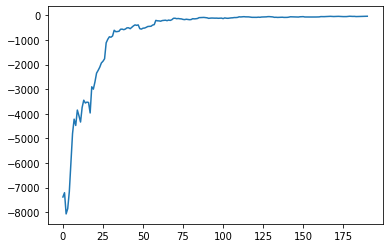

In [40]:
plt.plot(moving_average(rewards,10))

We use a simple for loop to change the hyper-parameters value for a specific number of episodes for each value.

In [ ]:
#Gamma/alpha hyperparameter search
#initialize the enviorment
env =  WareEnv()
env.reset()
#set initial parameter values
exploration = 0.7 #epsilon
episodes = 1000
rewards = []
steps_episode = []
episode_score = 0
ALPHA=0.7
GAMMA = 0.7
episodes = 100
epsilon = 0.3
episodes = 400
for GAMMA in np.linspace(0.1, 1, 20): # Gamma/alpha change for variable gridsearch
    wandb.init(
      # Set the project where this run will be logged
      project="Q Learning Part 4", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"gammaaa2{GAMMA}", 
      # Track hyperparameters and run metadata
      )
  
  # This simple block simulates a training loop logging metrics
    #initialize q-table at zero
    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    #ALPHA = ALPHA
    #GAMMA = 0.6
    #exploration = 0.1
    #episodes = episodes
    rewards = []
    steps_episode = []
    for ep in range(episodes): #number of episodes
      reward_sum = 0 #reward per episode
      state = env.reset()
      done = False
      steps = 0 #steps per episode
      while not done:
            if (random.random() < exploration):
                action = env.action_space.sample() # Explore a random action
            else:
                action = np.argmax(q_table[state]) # Use the action with the highest q-value
              
            next_state, reward, done, _ = env.step(action)
            reward_sum += reward #add reward to total
            steps += 1 #add step by 1
          
            prev_q = q_table[state, action]
            next_max_q = np.max(q_table[next_state])
            new_q = (1 - ALPHA) * prev_q + ALPHA * (reward + GAMMA * next_max_q)
            q_table[state, action] = new_q
          
            state = next_state #next state
      ##if done == New Episode
      episode_score +=1 #count number of episodes
      wandb.log({"Rewards": reward_sum, "Steps": steps, "Episodes": episode_score, "EPSILON": exploration
          
      }) #visualize here.
      #if done == New Episode
      rewards.append(reward_sum)
      print('done')
      steps_episode.append(steps)
  #all episodes finished
  # Mark the run as finished
    wandb.finish()

Epsilon decay

In [ ]:
#set inital hyper-parameters
ALPHA = 1
GAMMA = 0.7
exploration = 0.7
#number of episodes to train
episodes = 200
rewards = []
steps_episode = []
#Epsilon decay:
min_epsilon = 0.1
max_epsilon = 1
decay_rate = 0.005
exploration_list = []
#initialize Q table at 0
q_table = np.zeros([env.observation_space.n, env.action_space.n])
for ep in range(episodes): #number of episodes
  reward_sum = 0 #reward per episode
  state = env.reset()
  done = False
  episode_score = 0
  steps = 0 #steps per episode
  while not done:
            if (random.random() < exploration):
                action = env.action_space.sample() # Explore a random action
            else:
                action = np.argmax(q_table[state]) # Use the action with the highest q-value
              
            next_state, reward, done, _ = env.step(action)
            reward_sum += reward #add reward to total
            steps += 1 #add step by 1
          
            prev_q = q_table[state, action]
            next_max_q = np.max(q_table[next_state])
            new_q = (1 - ALPHA) * prev_q + ALPHA * (reward + GAMMA * next_max_q)
            q_table[state, action] = new_q
          
            state = next_state #next state
  ##if done == New Episode###
  episode_score +=1
  #reduce epsilon after every episode
  exploration = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*ep)
  exploration_list.append(exploration)
  #wandb.log({"Rewards": reward_sum, "Steps": steps, "Episodes": episode_score, "EPSILON": exploration
      
  # })
  #if done == New Episode
  rewards.append(reward_sum) #episode rewards
  steps_episode.append(steps) #number of steps/episode
  #all episodes finished

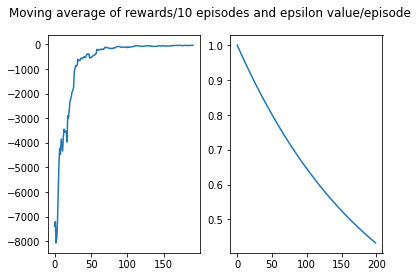

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Moving average of rewards/10 episodes and epsilon value/episode')
ax1.plot(moving_average(rewards, 10))
ax2.plot(exploration_list)


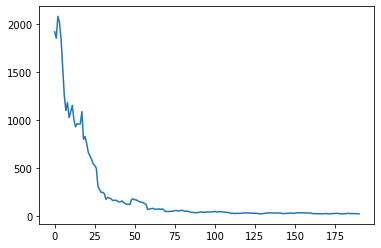

In [39]:
#plots moving average of steps/episode
a = moving_average(steps_episode, 10)
plt.plot(a)